In [1]:
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
dataset = pd.read_csv('data/final_student_level_data.csv')
dataset.drop(columns=[col for col in dataset.columns if\
                      (col.startswith("RTSM")&(col.endswith("No")))],
            inplace=True)
dataset["Roots_Mtgs"] = dataset[[col for col in dataset.columns if\
                      (col.startswith("RTSM"))]].sum(axis=1)
dataset.drop(columns=[col for col in dataset.columns if\
                      (col.startswith("RTSM"))],
            inplace=True)
dataset["Roots"] = np.where(dataset["Roots_Mtgs"]>0,1,0)
#dataset["AGEC_NEW"].fillna(dataset["AGEC_NEW"].median(),inplace=True)
dataset.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,SCHID,UID,ID,SCHTREAT_(1) Treatment school (Roots meetings 2012-2013),TREAT_(1) Treatment,TREAT_(2) Control,DE1,...,TOMEMF_(1) Yes,TOMEPM_(1) Yes,TOMETHP_(1) Yes,TOMERE_(1) Yes,TOMESG_(1) Yes,TOMESU_(1) Yes,Baseline_Conflict_Score,Network_Effect,Roots_Mtgs,Roots
0,0,0,0,1,100001,1,1,0,0,0,...,0,0,0,0,0,1,1.0,0.0,0,0
1,1,1,1,1,100002,2,1,0,1,0,...,0,0,0,0,0,0,1.0,0.0,0,0
2,2,2,2,1,100003,3,1,0,0,0,...,1,1,0,0,0,1,-3.0,0.5,0,0
3,3,3,3,1,100004,4,1,0,0,0,...,0,0,0,0,0,1,0.0,0.5,0,0
4,4,4,4,1,100005,5,1,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0,0


In [3]:
dataset["Roots"].value_counts()

0    22094
1      627
Name: Roots, dtype: int64

In [4]:
dataset.columns
dataset = dataset.drop(['Unnamed: 0'],axis=1)

<AxesSubplot:xlabel='Composite_Conflict_Score', ylabel='Density'>

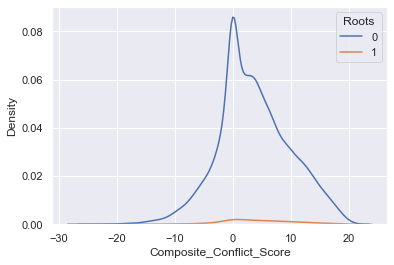

In [5]:
sns.kdeplot(data=dataset,x="Composite_Conflict_Score",hue="Roots")

Rename the columns for parsing causal graph (No number, space and brackets)

In [6]:
dataset = dataset.rename({"SCHTREAT_(1) Treatment school (Roots meetings 2012-2013)": "treatment_school",
"TREAT_(1) Treatment": "treatment_student",
"GENDER_(1) Boy": "is_boy",
"GR_(1) 6th grade":"sixth_grade",
"GR_(2) 7th grade":"seventh_grade",
"GR_(3) 8th grade":"eighth_grade",
"COLL_(1) Yes":"yes_college",
"COLL_(2) Maybe":"maybe_college",
"COLL_(3) Don't know":"not_sure_college",
"CELL_(1) Cell phone without Internet":"no_phone_internet",
"CELL_(2) Cell phone with Internet":"phone_internet",
"FSCH_(1) Do go to this school":"go_this_school",
"Network_Effect":'network_effect'
},axis=1)
dataset.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'SCHID', 'UID', 'ID',
       'treatment_school', 'treatment_student', 'TREAT_(2) Control', 'DE1',
       'DE2',
       ...
       'TOMEMF_(1) Yes', 'TOMEPM_(1) Yes', 'TOMETHP_(1) Yes', 'TOMERE_(1) Yes',
       'TOMESG_(1) Yes', 'TOMESU_(1) Yes', 'Baseline_Conflict_Score',
       'network_effect', 'Roots_Mtgs', 'Roots'],
      dtype='object', length=775)

In [7]:
dataset = dataset[['is_boy','AGEC_NEW','yes_college','phone_internet','go_this_school','Composite_Conflict_Score','Baseline_Conflict_Score','treatment_school','treatment_student','Roots','network_effect']]
dataset.shape
#dataset = dataset.sample(frac=0.2, replace=False, random_state=1)
dataset

,is_boy,AGEC_NEW,yes_college,phone_internet,go_this_school,Composite_Conflict_Score,Baseline_Conflict_Score,treatment_school,treatment_student,Roots,network_effect
0,0,11.0,1,1,0,-0.75,1.00,1,0,0,0.00
1,0,11.0,1,0,1,4.25,1.00,1,0,0,0.00
2,0,11.0,0,0,1,-9.25,-3.00,1,0,0,0.50
3,0,12.0,1,1,1,5.75,0.00,1,0,0,0.50
4,0,11.0,1,1,1,7.75,0.00,1,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
22716,1,14.0,1,0,1,7.00,-1.25,1,0,0,0.00
22717,1,13.0,0,0,0,-0.50,-0.25,1,0,0,0.75
22718,1,13.0,1,1,1,4.00,0.75,1,0,0,0.00
22719,1,13.0,1,0,0,-1.00,-0.25,1,0,0,0.00


## Causal Discovery Using PC Algorithm

Depth=6, working on node 9: 100%|██████████| 10/10 [00:00<00:00, 422.60it/s]


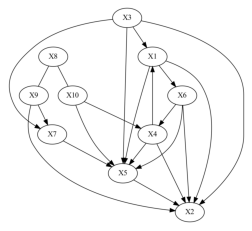

In [8]:
from causallearn.search.ConstraintBased.PC import pc

study_np = dataset.to_numpy()
cg = pc(study_np[:,1:],verbose=False)

# visualization using pydot
cg.draw_pydot_graph()

The result doesn't make sense for our study. Let's build a graph manually.

In [9]:
dataset.columns

Index(['is_boy', 'AGEC_NEW', 'yes_college', 'phone_internet', 'go_this_school',
       'Composite_Conflict_Score', 'Baseline_Conflict_Score',
       'treatment_school', 'treatment_student', 'Roots', 'network_effect'],
      dtype='object')

## Have a look on the correlation between treatment and outcome

Without treatment, the conflict level score is 3.629797682628768
With treatment, the conflict level score is 4.348086124401914


Text(0.5, 1.0, 'Scatter plot for Treatment Groups')

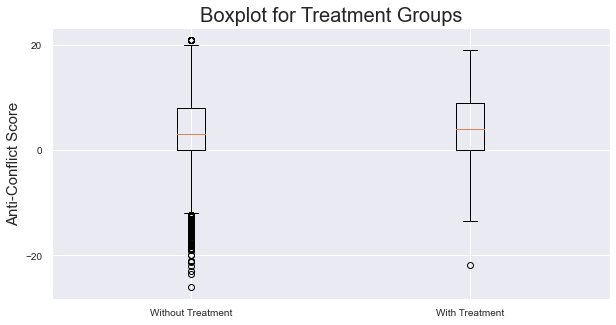

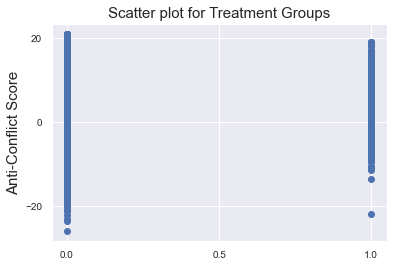

In [10]:
# Have a look on the average effect
import dowhy.datasets, dowhy.plotter

d0 = dataset[dataset.Roots == 0]
d0m = d0['Composite_Conflict_Score'].mean()
print('Without treatment, the conflict level score is',d0m)

d1 = dataset[dataset.Roots == 1]
d1m = d1['Composite_Conflict_Score'].mean()
print('With treatment, the conflict level score is',d1m)


plt.figure(figsize=(10,5))
plt.title('Boxplot for Treatment Groups',fontsize=20)
#plt.ylim((3,5))
plt.ylabel('Anti-Conflict Score',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
labels = ['Without Treatment','With Treatment']

plt.boxplot([d0['Composite_Conflict_Score'],d1['Composite_Conflict_Score']],widths=0.1,labels = labels)

plt.figure()
#plt.ylim((3,5))
plt.ylabel('Anti-Conflict Score',fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.scatter(dataset.Roots,dataset['Composite_Conflict_Score'])
plt.title('Scatter plot for Treatment Groups',fontsize=15)
#dowhy.plotter.plot_treatment_outcome(dataset['treatment'],dataset['Composite_Conflict_Score'])

Our causal graph logic is:
1. Age may cause the grade, go to college decision, phone internet rate, go this school and conflict level
2. Boy ratio may cause the college decisioin and conflict level
3. Grades cause affect other and affect go to college decision, phone internet rate, go this school and conflict level
4. College decision affect each other and conflict score
5. Internet may affect the conflict level
6. Go to this school affect the satisification of the school thus conflict level.



In [11]:
causal_graph2 = '''digraph{
    AGEC_NEW[label="Age"];
    Composite_Conflict_Score[label="Composite Conflict Score"][color=green];
    yes_college[label="Go College"];
    network_effect[label="Social Network Effect"]
    Baseline_Conflict_Score[label="Baseline Conflict Score"];
    phone_internet[label="Cell Phone With Internet"];
    treatment_school[label="Treatment School"]
    treatment_student[label="Treatment Student"]
    Roots[label="Roots"][color=blue];
    U[label="Unobserved Confounders"];
    go_this_school[label="Do Friends Go To This School"];
    network_effect -> {Roots, Composite_Conflict_Score};
    AGEC_NEW -> {yes_college,phone_internet,go_this_school,Composite_Conflict_Score,Roots,Baseline_Conflict_Score};
    phone_internet -> {Composite_Conflict_Score,Roots,Baseline_Conflict_Score};
    yes_college -> {Composite_Conflict_Score,Roots,Baseline_Conflict_Score};
    Roots -> {Composite_Conflict_Score};
    go_this_school-> {Composite_Conflict_Score,Roots,Baseline_Conflict_Score};
    treatment_school -> treatment_student;
    treatment_student -> {network_effect,Roots};
    Baseline_Conflict_Score -> {Roots, Composite_Conflict_Score};
}
'''

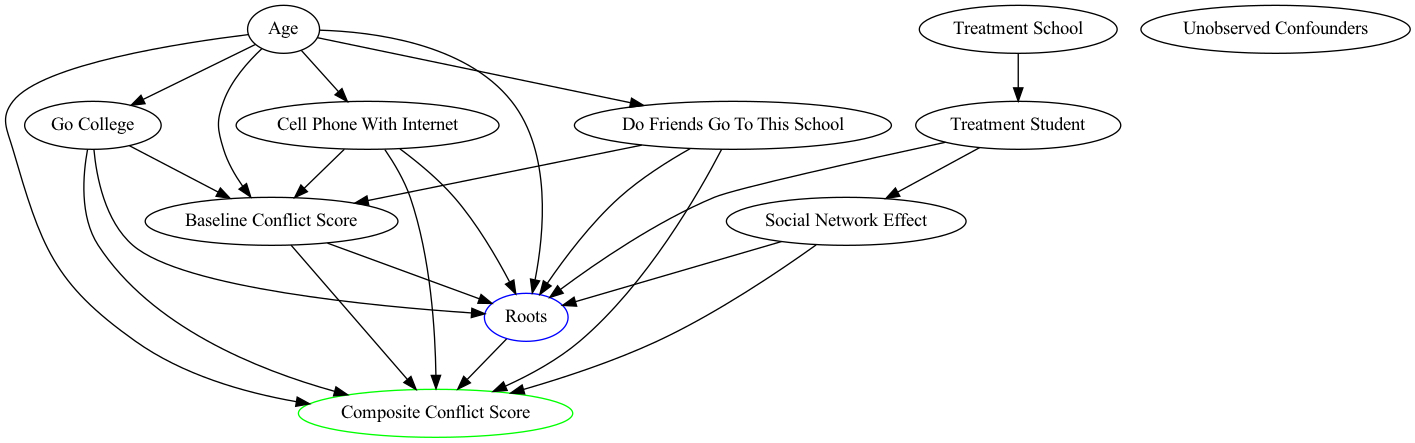

In [12]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph2.replace("\n", " ").replace(",",";"),
        treatment='Roots',
        outcome='Composite_Conflict_Score')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

# Identify the causal effect

In [13]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=False)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(Composite_Conflict_Score|phone_internet,go_this_school,tr
d[Roots]                                                                      

                                                                              
eatment_school,yes_college,network_effect,treatment_student,AGEC_NEW,Baseline_
                                                                              

                
Conflict_Score))
                
Estimand assumption 1, Unconfoundedness: If U→{Roots} and U→Composite_Conflict_Score then P(Composite_Conflict_Score|Roots,phone_internet,go_this_school,treatment_school,yes_college,network_effect,treatment_student,AGEC_NEW,Baseline_Conflict_Score,U) = P(Composite_Conflict_Score|Roots,phone_internet,go_this_school,treatment_school,yes_college,network_effect,treatment_student

## Linear regression for backdoor estimator

In [14]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.linear_regression",target_units="ate",
                                test_significance="bootstrap")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)
# It takes around 30 secs to run on my computer.

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(Composite_Conflict_Score|phone_internet,go_this_school,tr
d[Roots]                                                                      

                                                                              
eatment_school,yes_college,network_effect,treatment_student,AGEC_NEW,Baseline_
                                                                              

                
Conflict_Score))
                
Estimand assumption 1, Unconfoundedness: If U→{Roots} and U→Composite_Conflict_Score then P(Composite_Conflict_Score|Roots,phone_internet,go_this_school,treatment_school,yes_college,network_effect,treatment_student,AGEC_NEW,Baseline_Conflict_Score,U) = P(Composite_Conflict_Score|Roots,phone_internet,go_this_school,treatment_sch

In [15]:
model.summary()

"Model to find the causal effect of treatment ['Roots'] on outcome ['Composite_Conflict_Score']"

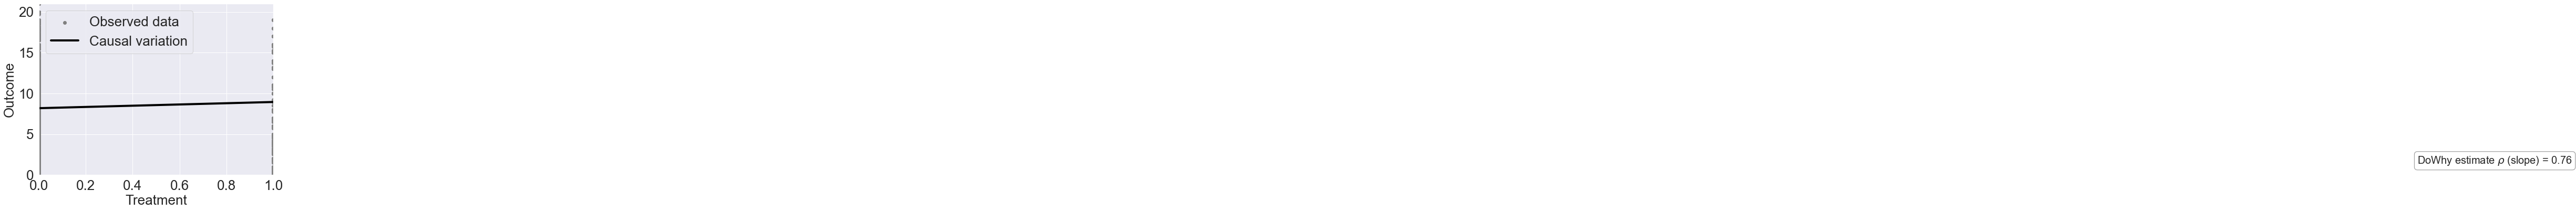

In [16]:
# Plot Slope of line between action and outcome = causal effect
dowhy.plotter.plot_causal_effect(estimate, dataset["Roots"], dataset["Composite_Conflict_Score"])

In [17]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:0.7606927467348745
New effect:0.7617383676171001



In [18]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:0.7606927467348745
New effect:4.440892098500626e-15
p value:0.0



In [19]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:0.7606927467348745
New effect:0.7742865228119967
p value:0.49



## Double Machine Learning Method

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
import econml

In [21]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

Error in sys.excepthook:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/causal_inference/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1934, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'RuntimeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/causal_inference/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1936, in showtraceback
    stb = self.InteractiveTB.structured_traceback(etype,
  File "/opt/anaconda3/envs/causal_inference/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1105, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/opt/anaconda3/envs/causal_inference/lib/python3.9/site-packages/IPython/core/ultratb.py", line 999, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/opt/anaconda3/envs/causal_inf

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(Composite_Conflict_Score|phone_internet,go_this_school,tr
d[Roots]                                                                      

                                                                              
eatment_school,yes_college,network_effect,treatment_student,AGEC_NEW,Baseline_
                                                                              

                
Conflict_Score))
                
Estimand assumption 1, Unconfoundedness: If U→{Roots} and U→Composite_Conflict_Score then P(Composite_Conflict_Score|Roots,phone_internet,go_this_school,treatment_school,yes_college,network_effect,treatment_student,AGEC_NEW,Baseline_Conflict_Score,U) = P(Composite_Conflict_Score|Roots,phone_internet,go_this_school,treatment_sch

In [22]:
refute1_results=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:1.3609966204626314
New effect:1.3844615092587562



In [23]:
refute2_results=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)
# It takes around 1 min 30 secs to run on my computer

Refute: Use a Placebo Treatment
Estimated effect:1.3609966204626314
New effect:0.0
p value:1.0



In [24]:
refute3_results=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter")
print(refute3_results)
# It takes around 2 mins to run on my computer

Refute: Use a subset of data
Estimated effect:1.3609966204626314
New effect:1.2599805264731745
p value:0.37

